In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import json
import os
import pytorch_lightning as pl
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid 
from torchvision import models
from PIL import Image
from pytorch_lightning.callbacks import early_stopping, model_checkpoint, ProgressBar
from pl_bolts.models.self_supervised import Moco_v2, BYOL
from pl_bolts.transforms.dataset_normalizations import imagenet_normalization
import tqdm
from sklearn.decomposition import PCA
import gc
from torchvision.io import ImageReadMode, read_image
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline

In [2]:
# first we have to create a dataset that loads slide by slide

class Camelyon16PreprocesseSlidedDataset(torch.utils.data.Dataset):
    """
    Dataset of unlabelled patches
    """
    
    def __init__(self, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.data["slide"] = self.data["path"].str.split("/", expand=True)[1]
        groups = self.data.groupby("slide")
        self.slidenames = np.unique(self.data["slide"])
        self.patchesByslide = list(groups.groups.values())
        self.transforms = transforms
        
    def __len__(self):
        return len(self.patchesByslide)

    def __getitem__(self, idx):
        patches = self.data.iloc[self.patchesByslide[idx]]

#         ids = np.arange(0, len(patches))
#         np.random.shuffle(ids)
#         patches = patches.iloc[ids]

        imgs = torch.stack([self.transforms(read_image(path, ImageReadMode.RGB)) for path in tqdm.tqdm(patches["path"])])

        global_label = patches["global_class"].iloc[0]
        local_labels = patches["local_class"].to_numpy()
        
        return imgs, (global_label, local_labels)
  

In [3]:
logger = TensorBoardLogger("lightning_logs", default_hp_metric=False, name="LatentSpace")
data_transform = transforms.Compose([transforms.Resize(32)])

In [4]:
dataset = Camelyon16PreprocesseSlidedDataset("processed_data/data.csv", data_transform)

In [6]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



230

In [12]:
def visualize(filename, dataset, logger, global_step=0):
    slidename = os.path.basename(filename).split(".")[0]
    idx = np.argmax(dataset.slidenames == slidename)
    tag = filename.split("_")[2]
    
    with np.load(filename, "r") as data:
        imgs_features = data["imgs"]
        local_labels = data["labels"][:len(imgs_features)]

    x = imgs_features
    res = list()
    n_cluster = range(2,20)
    for n in tqdm.tqdm(n_cluster):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(x)
        res.append(np.average(np.min(cdist(x, kmeans.cluster_centers_, 'cosine'), axis=1)))

    plt.plot(n_cluster, res)
    plt.title('elbow curve')
    plt.show()

encoded_data_resnet18/tumor_100.npz



100%|███████████████████████████████████████████| 18/18 [04:56<00:00, 16.46s/it]


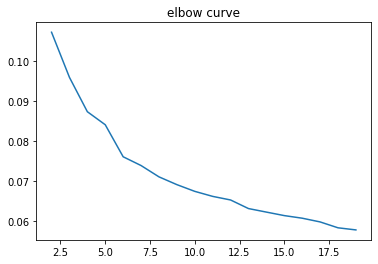

In [11]:
for i, file in enumerate(sorted(glob.glob("encoded_data_[r]*/tumor_100.npz"))):
    print(file)
    visualize(file, dataset, logger, i)

#     idx = int(file.split("_")[2])
    
#     with np.load(file, "r") as data:
#         imgs_features = data["imgs"]
#         local_labels = data["labels"][:len(imgs_features)]

#     imgs, _ = dataset[idx]
    
#     logger.experiment.add_embedding(imgs_features,local_labels, imgs[:len(imgs_features)]/255, global_step=i)